In [1]:
COLAB_NOTEBOOK = False

https://colab.research.google.com/drive/1iLOEsvbyC5gk5a-zPwOSlUbYv6B0oUm2

In [2]:
if COLAB_NOTEBOOK:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if inside colab notebook, copy the dataset to the workspace
if COLAB_NOTEBOOK:
  !unzip -n "/content/drive/MyDrive/Colab Notebooks/data/Cat_Dog_data.zip" -d "/content/Cat_Dog_data/"

print("********************* DONE *********************")

# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
from collections import OrderedDict
import time
from tqdm import tqdm

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [5]:
data_dir = '/content/Cat_Dog_data/Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # using mean and std of pre-trained model
])

test_transforms = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [6]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [7]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [8]:
import time

In [9]:
TEST_CPU_VS_CUDA = False

if TEST_CPU_VS_CUDA:
  for device in ['cpu', 'cuda']:

      criterion = nn.NLLLoss()
      # Only train the classifier parameters, feature parameters are frozen
      optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

      model.to(device)

      for ii, (inputs, labels) in enumerate(trainloader):

          # Move input and label tensors to the GPU
          inputs, labels = inputs.to(device), labels.to(device)

          start = time.time()

          outputs = model.forward(inputs)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if ii==3:
              break
          
      print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
epochs = 5
lr = 0.003
batch_size=64

In [20]:
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
model.to(device)

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
criterion = nn.NLLLoss()

# setup loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [21]:
def train_batch(device, model, inputs, labels):
  # Move input and label tensors to the GPU
  inputs, labels = inputs.to(device), labels.to(device)

  outputs = model.forward(inputs)
  loss = criterion(outputs, labels)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()

def eval_batch(device, model, inputs, labels):
  # Move input and label tensors to the GPU
  inputs, labels = inputs.to(device), labels.to(device)

  outputs = model.forward(inputs)
  loss = criterion(outputs, labels)

  ps = torch.exp(outputs)  # get probabilites; use exp() because LogSoftmax is used
  top_p, top_class = ps.topk(1, dim=1)  # peek the 1'st best probability for each example
  equals = top_class == labels.view(*top_class.shape)  # compare the top p class to the true labels; use (*) to unpack shape
  accuracy = torch.mean(equals.type(torch.FloatTensor))  # calculate accuracy using the mean between all samples in batch
  
  return loss.item(), accuracy.item()

In [22]:
training_losses = []  # per step
validation_losses = []  # per step
accuracy_history = []  # per step

for e in range(epochs):
  running_training_loss = 0
  running_validation_loss = 0
  running_accuracy = 0
  
  model.train()
  for ii, (inputs, labels) in enumerate(tqdm(trainloader, desc="Training", unit=" batch")):
    batch_loss = train_batch(device, model, inputs, labels)
    running_training_loss += batch_loss
  
  model.eval()
  with torch.no_grad():
    for jj, (inputs, labels) in enumerate(tqdm(testloader, desc="Validation", unit=" batch")):
      batch_loss, accuracy = eval_batch(device, model, inputs, labels)
      running_validation_loss += batch_loss
      running_accuracy += accuracy
      
  training_losses.append(running_training_loss/len(trainloader))
  validation_losses.append(running_validation_loss/len(testloader))
  accuracy_history.append(running_accuracy/len(testloader))

  print(f"Epoch {e+1}/{epochs}.. "
        f"Training Loss {running_training_loss/len(trainloader):.5f}.. "
        f"Validation Loss {running_validation_loss/len(testloader):.5f}.. "
        f"Accuracy {100*running_accuracy/len(testloader):.3f} % .. ")

  

Validation: 100%|██████████| 40/40 [00:30<00:00,  1.32 batch/s]


Epoch 1/5.. Training Loss 0.19800.. Validation Loss 0.05179.. Accuracy 97.930 % .. 


Validation: 100%|██████████| 40/40 [00:30<00:00,  1.32 batch/s]


Epoch 2/5.. Training Loss 0.15818.. Validation Loss 0.03805.. Accuracy 98.281 % .. 


Validation: 100%|██████████| 40/40 [00:30<00:00,  1.33 batch/s]


Epoch 3/5.. Training Loss 0.14943.. Validation Loss 0.03558.. Accuracy 98.359 % .. 


Validation: 100%|██████████| 40/40 [00:30<00:00,  1.33 batch/s]


Epoch 4/5.. Training Loss 0.15323.. Validation Loss 0.04235.. Accuracy 98.242 % .. 


Validation: 100%|██████████| 40/40 [00:30<00:00,  1.32 batch/s]

Epoch 5/5.. Training Loss 0.14872.. Validation Loss 0.04478.. Accuracy 98.164 % .. 


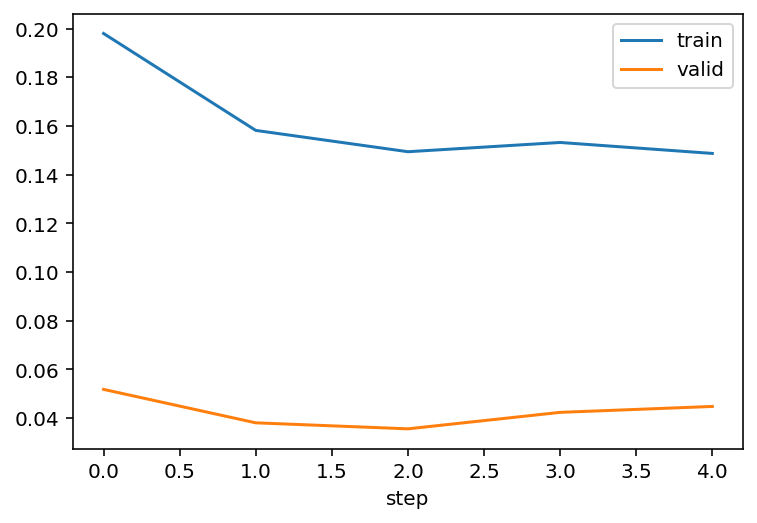

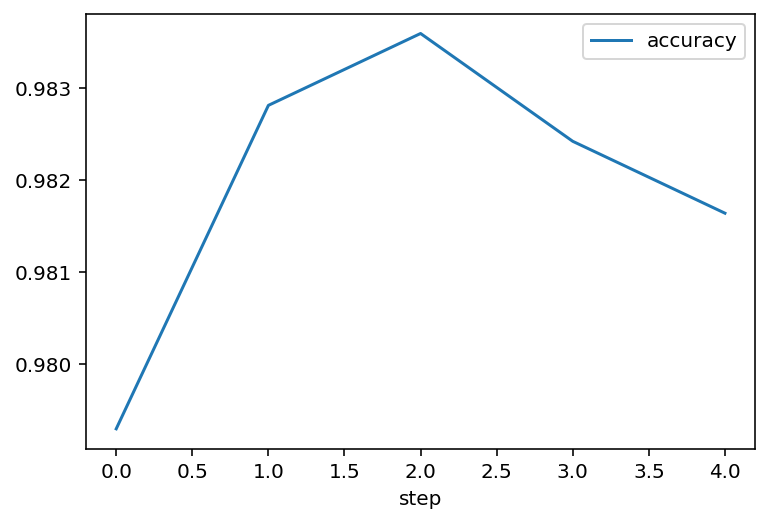

In [23]:
plt.figure()
plt.plot(training_losses)
plt.plot(validation_losses)
plt.xlabel("step")
plt.legend(["train", "valid"])
plt.show()

plt.figure()
plt.plot(accuracy_history)
plt.xlabel("step")
plt.legend(["accuracy"])
plt.show()